<a href="https://colab.research.google.com/github/InesAgudoMartin/UNIWALLET/blob/main/UNIWALLET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos las librerías necesarias y el archivo.

In [71]:
import requests
import warnings
import pandas as pd
import numpy as np
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import matplotlib.pyplot as plt

# URL directa al archivo CSV en GitHub
url = "https://raw.githubusercontent.com/InesAgudoMartin/UNIWALLET/main/expense_data_1.csv"
nombre = 'expense_data_1.csv'

# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
    # Guardar el contenido del archivo en un archivo local
    with open(nombre, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Archivo descargado exitosamente.


Cargamos el archivo de 'expense_data_1.csv' en un DataFrame de pandas que llamamos `df`.

In [72]:
df = pd.read_csv('expense_data_1.csv')

df.head(11)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Account,Category,Subcategory,Note,INR,Income/Expense,Note.1,Amount,Currency,Account.1
0,3/2/2022 10:11,CUB - online payment,Food,NaN,Brownie,50.00,Expense,NaN,50.00,INR,50.00
1,3/2/2022 10:11,CUB - online payment,Other,NaN,To lended people,300.00,Expense,NaN,300.00,INR,300.00
2,3/1/2022 19:50,CUB - online payment,Food,NaN,Dinner,78.00,Expense,NaN,78.00,INR,78.00
3,3/1/2022 18:56,CUB - online payment,Transportation,NaN,Metro,30.00,Expense,NaN,30.00,INR,30.00
4,3/1/2022 18:22,CUB - online payment,Food,NaN,Snacks,67.00,Expense,NaN,67.00,INR,67.00
5,3/1/2022 18:22,CUB - online payment,Other,NaN,From vicky,100.00,Income,NaN,100.00,INR,100.00
6,3/1/2022 18:21,CUB - online payment,Other,NaN,From dad,500.00,Income,NaN,500.00,INR,500.00
7,2/28/2022 11:56,CUB - online payment,Food,NaN,Pizza,339.15,Expense,NaN,339.15,INR,339.15
8,2/28/2022 11:45,CUB - online payment,Other,NaN,From kumara,200.00,Income,NaN,200.00,INR,200.00
9,2/27/2022 15:29,CUB - online payment,Food,NaN,Lunch,243.00,Expense,NaN,243.00,INR,243.00


Creamos una copia de `df` para modificarla sin afectar al original

In [73]:
ds = df.copy()
id(df), id(ds)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(133310281650560, 133310323189088)

###**Limpieza y preprocesamiento de la base de datos**

Tenemos un DataFrame con 541909 registros y 8 atributos.

In [74]:
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(277, 11)

In [75]:
df.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Account,Category,Subcategory,Note,INR,Income/Expense,Note.1,Amount,Currency,Account.1
0,3/2/2022 10:11,CUB - online payment,Food,NaN,Brownie,50.0,Expense,NaN,50.0,INR,50.0
1,3/2/2022 10:11,CUB - online payment,Other,NaN,To lended people,300.0,Expense,NaN,300.0,INR,300.0
2,3/1/2022 19:50,CUB - online payment,Food,NaN,Dinner,78.0,Expense,NaN,78.0,INR,78.0


El DataFrame (df) contiene los gastos de una persona a lo largo del tiempo. Para cada gasto registrado, se incluye la fecha y hora de la transacción, la cuenta utilizada para el pago, la categoría y subcategoría del gasto, una nota opcional para proporcionar detalles adicionales sobre la transacción, el importe en la moneda local (INR en este caso), si la transacción fue un ingreso o un gasto, y el importe del gasto. Esta información permite un análisis detallado de los hábitos de gasto de la persona, así como la evaluación de los patrones de gastos a lo largo del tiempo.

In [76]:
df.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Date', 'Account', 'Category', 'Subcategory', 'Note', 'INR',
       'Income/Expense', 'Note.1', 'Amount', 'Currency', 'Account.1'],
      dtype='object')

Vamos a eliminar las columnas de subcategoría y de note.1 porque están llenas de NaN. Además, como las cantidades están expresadas en INR (código de moneda ISO 4217 para la Rupia India), vamos a pasarlo a € (multiplicando a 0.011).

Con los siguientes tipos:

In [77]:
df.dtypes

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Date               object
Account            object
Category           object
Subcategory       float64
Note               object
INR               float64
Income/Expense     object
Note.1            float64
Amount            float64
Currency           object
Account.1         float64
dtype: object

Aparecen NaN's en el atributo `Subcategory` y `Note.1`, veremos qué porcentaje suponen y qué medidas tomar en base a ello.

In [78]:
df.isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Date                0
Account             0
Category            0
Subcategory       277
Note                4
INR                 0
Income/Expense      0
Note.1            277
Amount              0
Currency            0
Account.1           0
dtype: int64

In [79]:
conteo_nans = df['Subcategory'].isna().sum()
conteo_no_nans = len(df) - conteo_nans

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


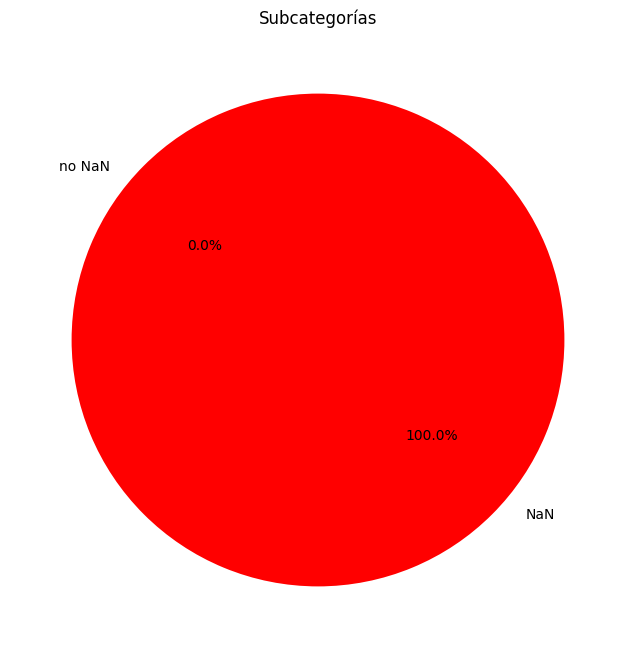

In [80]:
import matplotlib.pyplot as plt

sizes = [conteo_nans, conteo_no_nans]
labels = ['NaN','no NaN']

# Crear un gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',colors=['red','green'], startangle=140)

# Añadir título
plt.title('Subcategorías')

# Mostrar el gráfico
plt.show()


Las entradas con descripciones NaN suponen un porcentaje muy bajo de las totales, podríamos eliminar dichas entradas pero antes limpiaremos la base de datos ya que podrían ser eliminados igualmente si pertenecen a registros con otros datos inconsistentes.

Como hemos visto que muchas de las columnas son iguales o que están vacías, vamos a eliminaras directamente.

In [81]:
# Lista de columnas a eliminar
columnas_eliminar = ['Subcategory', 'INR', 'Note.1', 'Currency', 'Account.1']

# Eliminar las columnas del DataFrame
df = df.drop(columnas_eliminar, axis=1)

# Mostrar el DataFrame actualizado
df.head(11)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Account,Category,Note,Income/Expense,Amount
0,3/2/2022 10:11,CUB - online payment,Food,Brownie,Expense,50.00
1,3/2/2022 10:11,CUB - online payment,Other,To lended people,Expense,300.00
2,3/1/2022 19:50,CUB - online payment,Food,Dinner,Expense,78.00
3,3/1/2022 18:56,CUB - online payment,Transportation,Metro,Expense,30.00
4,3/1/2022 18:22,CUB - online payment,Food,Snacks,Expense,67.00
5,3/1/2022 18:22,CUB - online payment,Other,From vicky,Income,100.00
6,3/1/2022 18:21,CUB - online payment,Other,From dad,Income,500.00
7,2/28/2022 11:56,CUB - online payment,Food,Pizza,Expense,339.15
8,2/28/2022 11:45,CUB - online payment,Other,From kumara,Income,200.00
9,2/27/2022 15:29,CUB - online payment,Food,Lunch,Expense,243.00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


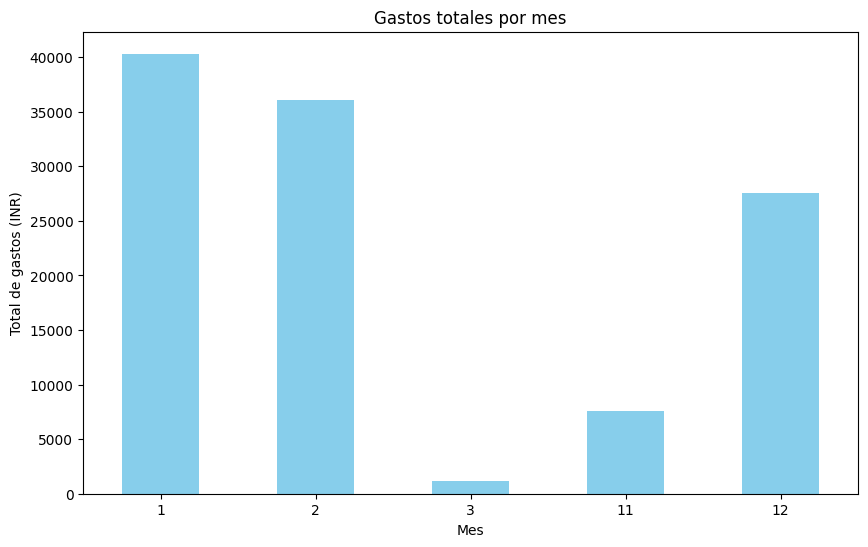

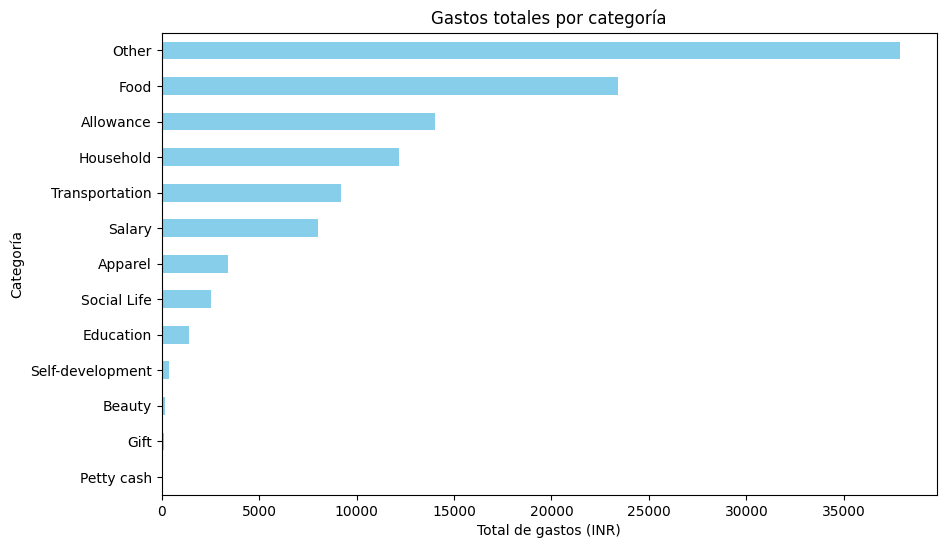

In [82]:
import matplotlib.pyplot as plt


# Convertir la columna 'Date' a formato datetime
ds['Date'] = pd.to_datetime(ds['Date'])

# Extraer el mes de la fecha
ds['Month'] = ds['Date'].dt.month

# Calcular el total de gastos por mes
total_gastos_mes = ds.groupby('Month')['Amount'].sum()

# Crear un gráfico de barras de gastos por mes
plt.figure(figsize=(10, 6))
total_gastos_mes.plot(kind='bar', color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Total de gastos (INR)')
plt.title('Gastos totales por mes')
plt.xticks(rotation=0)
plt.show()


# Calcular el total de gastos por categoría
total_gastos_categoria = ds.groupby('Category')['Amount'].sum().sort_values()

# Crear un gráfico de barras horizontal de gastos por categoría
plt.figure(figsize=(10, 6))
total_gastos_categoria.plot(kind='barh', color='skyblue')
plt.xlabel('Total de gastos (INR)')
plt.ylabel('Categoría')
plt.title('Gastos totales por categoría')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


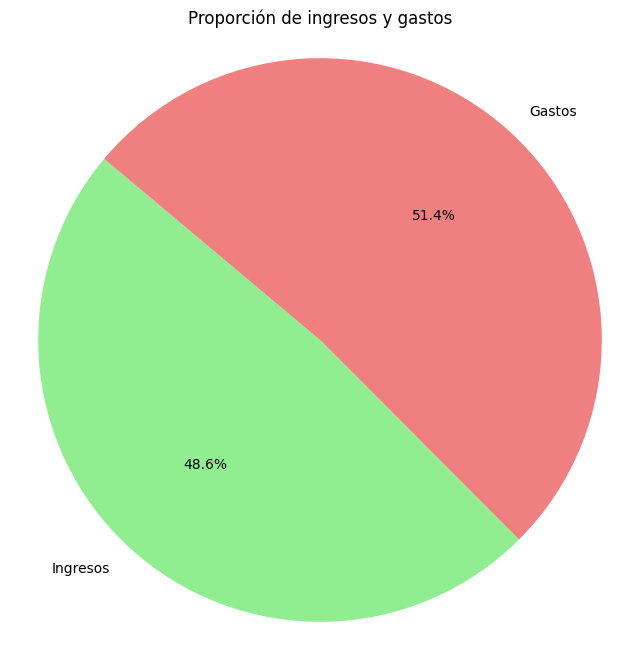

In [83]:
# Calcular la suma de ingresos y gastos
total_ingresos = ds[ds['Income/Expense'] == 'Income']['Amount'].sum()
total_gastos = ds[ds['Income/Expense'] == 'Expense']['Amount'].sum()

# Crear un gráfico de pastel de proporción de ingresos y gastos
plt.figure(figsize=(8, 8))
plt.pie([total_ingresos, total_gastos], labels=['Ingresos', 'Gastos'], autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'lightcoral'])
plt.title('Proporción de ingresos y gastos')
plt.axis('equal')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


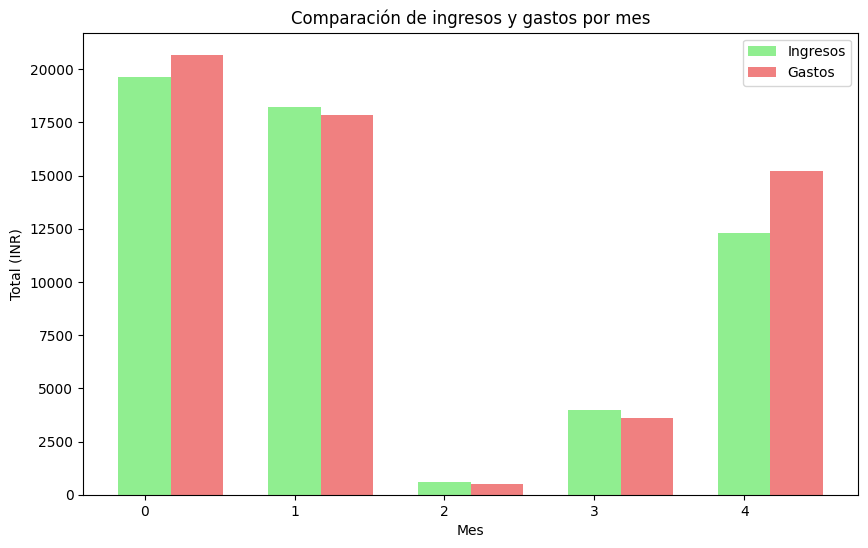

In [84]:
# Calcular el total de ingresos y gastos por mes
total_ingresos_mes = ds[ds['Income/Expense'] == 'Income'].groupby(ds['Date'].dt.month)['Amount'].sum()
total_gastos_mes = ds[ds['Income/Expense'] == 'Expense'].groupby(ds['Date'].dt.month)['Amount'].sum()

# Crear una figura y ejes
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Definir el ancho de las barras
bar_width = 0.35

# Calcular la posición de los grupos de barras
index = np.arange(len(total_ingresos_mes))

# Dibujar las barras de ingresos
ax.bar(index, total_ingresos_mes, bar_width, color='lightgreen', label='Ingresos')

# Dibujar las barras de gastos con un desplazamiento a la derecha
ax.bar(index + bar_width, total_gastos_mes, bar_width, color='lightcoral', label='Gastos')

# Etiquetas y título
ax.set_xlabel('Mes')
ax.set_ylabel('Total (INR)')
ax.set_title('Comparación de ingresos y gastos por mes')


# Mostrar la leyenda
ax.legend()

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


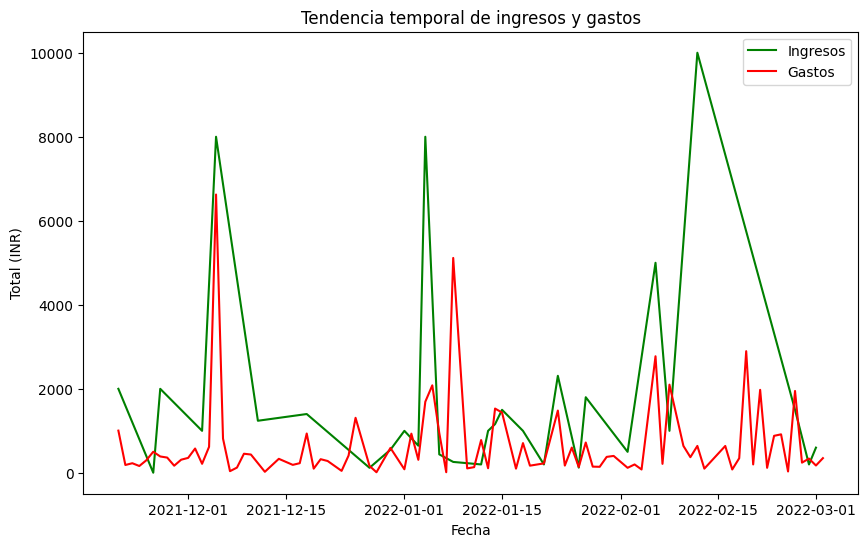

In [85]:
# Calcular el total de ingresos y gastos por fecha
total_ingresos_fecha = ds[ds['Income/Expense'] == 'Income'].groupby(ds['Date'].dt.date)['Amount'].sum()
total_gastos_fecha = ds[ds['Income/Expense'] == 'Expense'].groupby(ds['Date'].dt.date)['Amount'].sum()

# Crear un gráfico de líneas de tendencia temporal de ingresos y gastos
plt.figure(figsize=(10, 6))
plt.plot(total_ingresos_fecha.index, total_ingresos_fecha, label='Ingresos', color='green')
plt.plot(total_gastos_fecha.index, total_gastos_fecha, label='Gastos', color='red')
plt.xlabel('Fecha')
plt.ylabel('Total (INR)')
plt.title('Tendencia temporal de ingresos y gastos')
plt.legend()
plt.show()
